In [45]:

import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy
from skimage import color


mi.set_variant('cuda_ad_rgb')

In [46]:
from mitsuba import ScalarTransform4f as T
# importing the class which is used to set up transformations such as position and orientation of cameras


# we need several renderings, so we have to set up multiple viewpoints/sensors/cameras. these lines of code are for setting up the scene.
sensor_count = 8
sensors = []

# golden ratio is used to evenly distribute the cameras around the object
golden_ratio = (1+5**0.2)/2
for i in range(sensor_count):
    # theta and phi are spherical angles uniquely calculated for each cameras to avoid clustering
    theta = 2 * dr.pi * i/golden_ratio
    phi = dr.acos(1-2*(i+0.5)/sensor_count)
    # distance between each camera is d
    d = 5
    # origin of the cameras
    origin = [
        d * dr.cos(theta) * dr.sin(phi),
        d * dr.sin(theta) * dr.sin(phi),
        d * dr.cos(phi)
    ]
    # defining and appending the sensors/cameras
    sensors.append(mi.load_dict({
        'type': 'perspective',
        'fov': 45,
        'to_world': T.look_at(target=[0, 0, 0], origin=origin, up=[0, 1, 0]),
        'film': {
            'type': 'hdrfilm',
            'width': 256, 'height': 256,
            'filter': {'type': 'gaussian'},
            'sample_border': True,
        },
        'sampler': {
            'type': 'independent',
            'sample_count': 128
        },
    }))

In [47]:
scene_dict = {
    # the dictionary scene_dict is defining a scene
    'type': 'scene',
    # an integrator computes how the light interacts with the scene.
    'integrator':
    {
        # this type of integrator is suitable for simple and direct illumination calculations
        'type': 'direct_projective',
        # to disable indirect visibility effects such as reflections and refractions
        'sppi': 0,
    },
    'emitter': {
        'type': 'envmap',
        'filename': r"C:\Users\HTCV_DIRME\Desktop\Projectwork\scenes\envmap2.exr"
    },
    'shape': {
        'type': 'ply',
        'filename': r"C:\Users\HTCV_DIRME\Desktop\Projectwork\scenes\suzanne.ply",
        'bsdf': {'type': 'diffuse'}
    }
}
# loading the scene.
scene_target = mi.load_dict(scene_dict)

In [48]:
def plot_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))
    for i in range(len(images)):
        axs[i].imshow(mi.util.convert_to_bitmap(images[i]))
        axs[i].axis('off')
    plt.savefig("reference_images_suanne.png", dpi=300, bbox_inches="tight")
    plt.show()


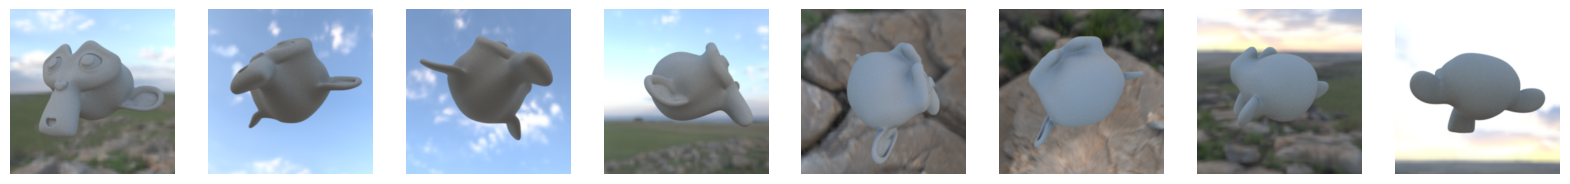

reference image rendered


In [49]:
ref_images = [mi.render(scene_target, sensor=sensors[i], spp=256)
              for i in range(sensor_count)]
plot_images(ref_images)
print('reference image rendered')

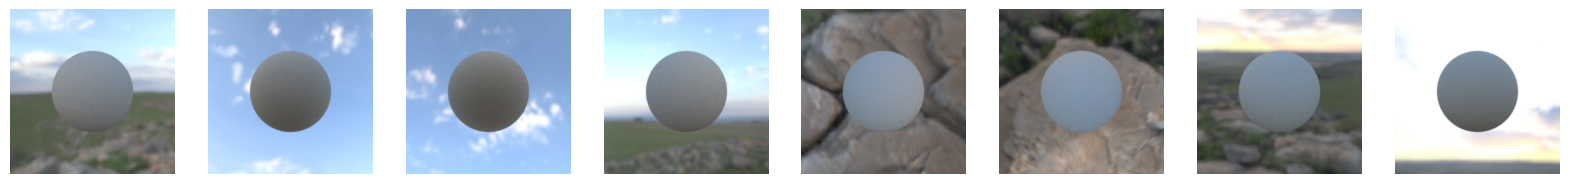

Sphere rendered 


In [50]:
scene_dict['shape']['filename'] = r"C:\Users\HTCV_DIRME\Desktop\Projectwork\scenes\ico_10k.ply"
scene_source = mi.load_dict(scene_dict)

init_image = [mi.render(scene_source, sensor=sensors[i], spp=128)
              for i in range(sensor_count)]
plot_images(init_image)
print('Sphere rendered ')

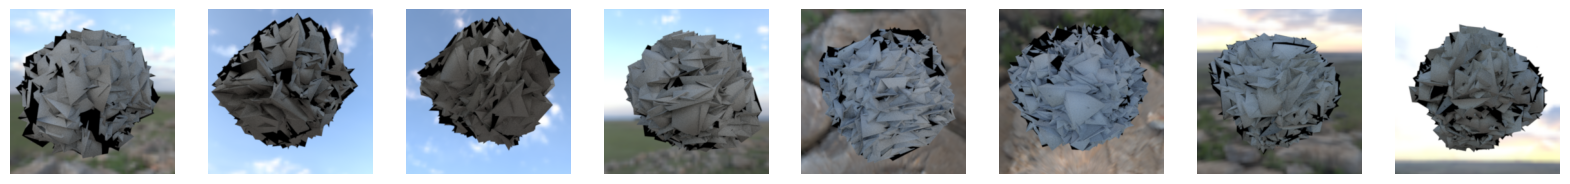

Rendering by naive approach done and resulting mesh is tangled 


In [51]:
params = mi.traverse(scene_source)
opt = mi.ad.Adam(lr=3e-2)
opt['shape.vertex_positions'] = params['shape.vertex_positions']

for it in range(5):
    total_loss = mi.Float(0.0)

    for sensor_index in range(sensor_count):
        params.update(opt)
        img = mi.render(scene_source, params,
                        sensor=sensors[sensor_index], seed=it)

        loss = dr.mean(dr.sqr(img-ref_images[sensor_index]))
        dr.backward(loss)

        opt.step()
        total_loss += loss[0]
    print(f"Iteration {1+it:03d}: Loss = {total_loss[0]:6f}", end='\r')

final_images = [mi.render(scene_source, sensor=sensors[i], spp=128)
                for i in range(sensor_count)]
plot_images(final_images)
print("Rendering by naive approach done and resulting mesh is tangled ")


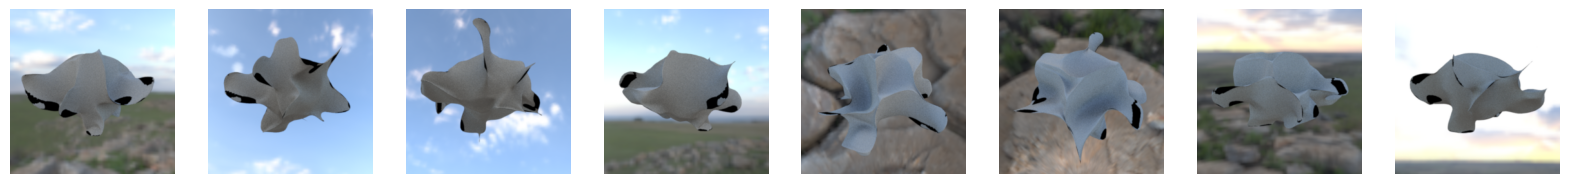

Rendering with large step optimization is done


In [52]:
scene_source = mi.load_dict(scene_dict)
params = mi.traverse(scene_source)

# using large step optimization uses smoothing of gradient.
# it uses a latent variable u which is defined as u = (I +lambda*L)v , where v is the vertex positions, L is laplacian of given mesh and lambda is ahyper parameter.

lambda_ = 25
# LargeSteps is instantiated with starting shape's vertex positions and faces
ls = mi.ad.LargeSteps(params['shape.vertex_positions'],
                      params['shape.faces'], lambda_)
# a variant of Adam to the one used before with a uniform second moment
opt = mi.ad.Adam(lr=1e-1, uniform=True)
# to_differential() method is used for intializing the latent variable
opt['u'] = ls.to_differential(params['shape.vertex_positions'])

iterations = 100 if 'PYTEST_CURRENT_TEST' not in os.environ else 5
for it in range(iterations):
    total_loss = mi.Float(0.0)

    for sensor_indec in range(sensor_count):
        # retreving the vertex positions from the later variable
        params['shape.vertex_positions'] = ls.from_differential(opt['u'])
        params.update()

        img = mi.render(scene_source, params,
                        sensor=sensors[sensor_indec], seed=it)

        # loss calculation
        loss = dr.mean(dr.abs(img - ref_images[sensor_index]))

        dr.backward(loss)
        opt.step()

        total_loss += loss[0]
    print(f"Iteration {1+it:03d}: Loss = {total_loss[0]:6f}", end='\r')

# update the mesh after the last iteration's gradient step
params['shape.vertex_positions'] = ls.from_differential(opt['u'])
params.update()

final_images = [mi.render(scene_source, sensor=sensors[i], spp=128)
                for i in range(sensor_count)]
plot_images(final_images)
print('Rendering with large step optimization is done')

In [53]:
# v_np = params['shape.vertex_positions'].numpy().reshape((-1, 3)
#                                                         ).astype(np.float64)
# f_np = params['shape.faces'].numpy().reshape((-1, 3))

# # algorithm takes target edge length as the input argument.
# # this edge length refines the mesh. we consider it to be half of the mean edge length
# # l0 ,l1,l2 , because we have three vertices in a triangular mesh
# l0 = np.linalg.norm(v_np[f_np[:, 0]] - v_np[f_np[:, 1]], axis=1)
# l1 = np.linalg.norm(v_np[f_np[:, 1]] - v_np[f_np[:, 2]], axis=1)
# l2 = np.linalg.norm(v_np[f_np[:, 2]] - v_np[f_np[:, 0]], axis=1)
# target_l = np.mean([l0, l1, l2]) / 2

# v_new, f_new = remesh_botsch(v_np, f_np, i=5, h=target_l, project=True)


# # the new vertices and faces v_new and f_new has to be passed to our Mitsuba.
# params['shape.vertex_positions'] = mi.Float(v_new.flatten().astype(np.float32))
# params['shape.faces'] = mi.Int(f_new.flatten())
# params.update()

# # because the mesh topology has changed now, we need to compute the new latent variable.
# ls = mi.ad.LargeSteps(params['shape.vertex_positions'],
#                       params['shape.faces'], lambda_)
# opt = mi.ad.Adam(lr=1e-1, uniform=True)
# opt['u'] = ls.to_differential(params['shape.vertex_positions'])

# # enabling indirect visibility
# integrator = mi.load_dict({
#     'type': 'direct_projective'
# })

# # optimization step
# iterations = 100 if 'PYTEST_CURRENT_TEST' not in os.environ else 5
# for it in range(iterations):
#     total_loss = mi.Float(0.0)
#     for sensor_index in range(sensor_count):
#         params['shape.vertex_positions'] = ls.from_differential(opt['u'])
#         params.update()

#         image = mi.render(
#             scene_source, params, sensor=sensors[sensor_index], seed=it, integrator=integrator)
#         loss = dr.mean(dr.abs(image-ref_images[sensor_index]))

#         dr.backward(loss)
#         total_loss += loss[0]
#     opt.step()
#     print(f"Iteration {1+it:03d}: Loss = {total_loss[0]:6f}", end='\r')

# params['shape.vertex_positions'] = ls.from_differential(opt['u'])
# params.update()

# final_images = [mi.render(scene_source, sensor=sensors[i], spp=128)
#                 for i in range(sensor_count)]
# fig, ax = plt.subplots(nrows=2, ncols=sensor_count,
#                        figsize=(5*sensor_count, 10))
# ax[0][0].set_title("Reference", y=0.3, x=-0.1, rotation=90, fontsize=20)
# ax[1][0].set_title("Optimized shape", y=0.2, x=-0.1, rotation=90, fontsize=20)
# for i in range(sensor_count):
#     ax[0][i].imshow(mi.util.convert_to_bitmap(ref_images[i]))
#     ax[0][i].axis('off')
#     ax[1][i].imshow(mi.util.convert_to_bitmap(final_images[i]))
#     ax[1][i].axis('off')
# plt.savefig("reference_images_suanne.png", dpi=300, bbox_inches="tight")
# plt.show()
# print("remeshing is done")

NameError: name 'remesh_botsch' is not defined